In [1]:
import numpy as np
import numpy
from nbodykit.lab import BigFileMesh, BigFileCatalog
from pmesh.pm import ParticleMesh
import os, sys
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/dask/context.py:23: UserWarning: The dask.set_options function has been deprecated. Please use dask.config.set instead
  warnings.warn("The dask.set_options function has been deprecated. "


In [2]:
import tensorflow as tf
# tf.enable_eager_execution()

In [3]:
sys.path.append('/global/homes/c/chmodi/Programs/cosmo4d/train_nets-tflow/')
import tools 

sys.path.append('/global/homes/c/chmodi/Programs/cosmo4d/train_nets/')
import features as ft



In [4]:
# bs = 16
# nc = 4
# step = 5
# pm = ParticleMesh(BoxSize=bs, Nmesh = [nc, nc, nc], dtype='f4')

# nparticle = 2
# pos = bs*np.random.random(3*nparticle).reshape(-1, 3).astype(np.float32)

# mesh = pm.paint(pos)



# Paint and readout

In [6]:

def cic_paint(mesh, part, weight=None, cube_size=None):
    """
        - mesh is a cube
        - part is a list of particles (:, 3), positions in mesh units
        - weight is a list of weights (:)
        - cube_size is the size of the cube in mesh units
    """

    # Create a variable to store the input mesh
    var = tf.Variable(0, dtype=tf.float32)
    var = tf.assign(var, mesh, validate_shape=False)
#     var = mesh
    if weight is None: weight = np.ones(part.shape[0], dtype=part.dtype)
    if cube_size is None: cube_size = mesh.shape[0].value
    
    # Extract the indices of all the mesh points affected by each particles
    i000 = tf.cast(tf.floor(part), dtype=tf.int32)
    i100 = i000 + tf.constant([1, 0, 0])
    i010 = i000 + tf.constant([0, 1, 0])
    i001 = i000 + tf.constant([0, 0, 1])
    i110 = i000 + tf.constant([1, 1, 0])
    i101 = i000 + tf.constant([1, 0, 1])
    i011 = i000 + tf.constant([0, 1, 1])
    i111 = i000 + tf.constant([1, 1, 1])
    neighboor_coords = tf.stack([i000, i100, i010, i001,
                                 i110, i101, i011, i111], axis=1)
    kernel = 1. - tf.abs(tf.expand_dims(part, axis=1) - tf.cast(neighboor_coords, tf.float32))
    kernel = tf.reduce_prod(kernel, axis=-1, keepdims=False)
    kernel = tf.expand_dims(weight, axis=1) * kernel
        
#     if cube_size is not None:
    neighboor_coords = neighboor_coords % cube_size

    updated_mesh = tf.scatter_nd_add(var, tf.reshape(neighboor_coords, (-1, 3)),
                                     tf.reshape(kernel, (-1,)))
    return updated_mesh




def cic_readout(mesh, part, cube_size=None):
    """
        - mesh is a cube
        - part is a list of particles (:, 3), positions in mesh units
        - cube_size is the size of the cube in mesh units
    """

    if cube_size is None: cube_size = mesh.shape[0].value
    # Extract the indices of all the mesh points affected by each particles
    i000 = tf.cast(tf.floor(part), dtype=tf.int32)
    i100 = i000 + tf.constant([1, 0, 0])
    i010 = i000 + tf.constant([0, 1, 0])
    i001 = i000 + tf.constant([0, 0, 1])
    i110 = i000 + tf.constant([1, 1, 0])
    i101 = i000 + tf.constant([1, 0, 1])
    i011 = i000 + tf.constant([0, 1, 1])
    i111 = i000 + tf.constant([1, 1, 1])
    neighboor_coords = tf.stack([i000, i100, i010, i001,
                                 i110, i101, i011, i111], axis=1)
    kernel = 1. - tf.abs(tf.expand_dims(part, axis=1) - tf.cast(neighboor_coords, tf.float32))
    kernel = tf.reduce_prod(kernel, axis=-1, keepdims=False)
    
#     if cube_size is not None:
    neighboor_coords = neighboor_coords % cube_size

    meshvals = tf.gather_nd(mesh, neighboor_coords)
    weightedvals = tf.multiply(meshvals, kernel)
    value = tf.reduce_sum(weightedvals, axis=1)
    return value


def checkpaint():
    bs = 50
    nc = 16
    pm = ParticleMesh(BoxSize=bs, Nmesh = [nc, nc, nc], dtype='f4')
    nparticle = 100
    pos = bs*np.random.random(3*nparticle).reshape(-1, 3).astype(np.float32)
    wts = np.random.random(nparticle).astype(np.float32)
    
    pmmesh = pm.paint(pos, mass=wts)
    
    tfmesh = tf.zeros((nc, nc, nc), dtype=tf.float32)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        tfmesh = sess.run(cic_paint(tfmesh, pos*nc/bs, weight=wts))
    
    print(abs(pmmesh[...] - tfmesh).sum())


def checkreadout():
    bs = 50
    nc = 16
    pm = ParticleMesh(BoxSize=bs, Nmesh = [nc, nc, nc], dtype='f4')
    nparticle = 100
    pos = bs*np.random.random(3*nparticle).reshape(-1, 3).astype(np.float32)
    base = 100*np.random.random(nc**3).reshape(nc, nc, nc).astype(np.float32)
    
    pmmesh = pm.create(mode='real', value=base)    
    pmread = pmmesh.readout(pos)
    
    tfmesh = tf.constant(base, dtype=tf.float32)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        tfread = sess.run(cic_readout(tfmesh, pos*nc/bs))
    
    print(abs((pmread[...] - tfread)/pmread).sum())
#     print(abs(pmread[...] - tfread).sum()

In [7]:
checkpaint()
checkreadout()

3.1113985e-05
1.7280922164567113e-05


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel/__main__.py:99: DeprecationWarning: argument mode is deprecated. use type=real instead


# LPT

In [8]:
def laplace(k, v):
    kk = sum(ki ** 2 for ki in k)
    mask = (kk == 0).nonzero()
    kk[mask] = 1
    b = v / kk
    b[mask] = 0
    return b

def gradient(dir, order=1):
    if order == 0:
        def kernel(k, v):
            # clear the nyquist to ensure field is real
            mask = v.i[dir] != v.Nmesh[dir] // 2
            return v * (1j * k[dir]) * mask
    if order == 1:
        def kernel(k, v):
            cellsize = (v.BoxSize[dir] / v.Nmesh[dir])
            w = k[dir] * cellsize

            a = 1 / (6.0 * cellsize) * (8 * numpy.sin(w) - numpy.sin(2 * w))
            # a is already zero at the nyquist to ensure field is real
            return v * (1j * a)
    return kernel


def lpt1(dlin_k, q, resampler='cic'):
    """ Run first order LPT on linear density field, returns displacements of particles
        reading out at q. The result has the same dtype as q.
    """
    basepm = dlin_k.pm
        
    ndim = len(basepm.Nmesh)
    delta_k = basepm.create('complex', value=1)

    
    layout = basepm.decompose(q)
    local_q = layout.exchange(q)

    source = numpy.zeros((len(q), ndim), dtype=q.dtype)
    toret = []
    for d in range(len(basepm.Nmesh)):
        disp = dlin_k.apply(laplace) \
                    .apply(gradient(d), out=Ellipsis) \
                    .c2r(out=Ellipsis)
#         toret.append(dlin_k.apply(laplace).apply(gradient(d), out=Ellipsis))
        toret.append(disp)

        local_disp = disp.readout(local_q, resampler=resampler)
        source[..., d] = layout.gather(local_disp)
#     return toret
    return source




def tflaplace(v, gdict):
    kvec = gdict['kvec']
    kk = sum(ki**2 for ki in kvec)
    mask = (kk == 0).nonzero()
    kk[mask] = 1
    imask = (~(kk==0)).astype(int)
    b = tf.multiply(v, 1/kk)
    b = tf.multiply(b, imask)
    return b 


def tfgradient(v, dir, gdict):
    kvec = gdict['kvec']
    bs, nc = gdict['bs'], gdict['nc']
    cellsize = bs/nc
    w = kvec[dir] * cellsize
    a = 1 / (6.0 * cellsize) * (8 * numpy.sin(w) - numpy.sin(2 * w))
    ac = a*1j
    # a is already zero at the nyquist to ensure field is real
    return tf.multiply(v , ac)
    

def tflpt1(dlin_k, pos, gdict):
    """ Run first order LPT on linear density field, returns displacements of particles
        reading out at q. The result has the same dtype as q.
    """
    bs, nc = gdict['bs'], gdict['nc']        
#     kvec = tools.fftk((nc, nc, nc), bs)
#     gdict['kvec'] = kvec
    
    ones = tf.ones_like(dlin_k)
    lap = tflaplace(ones, gdict)
    
    displacement = tf.zeros_like(pos)
    displacement = []
    for d in range(3):
        kweight = tf.multiply(tfgradient(ones, d, gdict), lap)
        dispc = tf.multiply(kweight, dlin_k)
        disp = tf.multiply(tf.spectral.irfft3d(dispc), nc**3)
        displacement.append(cic_readout(disp, pos))

    return tf.stack(displacement, axis=1)


In [86]:
bs = 16
nc = 4
pm = ParticleMesh(BoxSize=bs, Nmesh = [nc, nc, nc], dtype='f4')
kvec = tools.fftk((nc, nc, nc), bs)
gdict = {'bs':bs, 'nc':nc, 'kvec':kvec}
nparticle = 2
pos = bs*np.random.random(3*nparticle).reshape(-1, 3).astype(np.float32)

white = pm.generate_whitenoise(100, mode='real')
whitec = white.r2c()
#
tmp = lpt1(whitec, pos)



/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel/__main__.py:9: DeprecationWarning: mode argument is deprecated, use type


In [87]:
# #Check here in lazy mode

#
# twhite = tf.constant(white[...])
# twhitec = tf.spectral.rfft3d(twhite)/tf.reduce_prod(twhite.shape).numpy()
# ttmp = tflpt1(twhitec, pos*nc/bs, gdict)

# print(tmp, ttmp.numpy())

# # ii = 1
# # jj = 2
# # for jj in [0, 1, 2]:
# # #     print(tmp[ii][jj].real/ ttmp.numpy()[ii][jj].real)
# #     print(tmp[ii][jj].imag - ttmp.numpy()[ii][jj].imag)

In [89]:
##Check here in sess run mode 

#
twhite = tf.constant(white[...])
twhitec = tf.multiply(tf.spectral.rfft3d(twhite), 1/nc**3)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    ttmp = sess.run(tflpt1(twhitec, pos*nc/bs, gdict))

print(tmp)
print(ttmp)



[[ 2.4192107   1.0869882   7.2817807 ]
 [-1.7688123   0.74984986 -1.0023885 ]]
[[ 2.4192107  1.0869882  7.2817802]
 [-1.7688122  0.7498498 -1.0023887]]


## lpt 2

In [24]:

def lpt2source(dlin_k):
    """ Generate the second order LPT source term.  """
    source = dlin_k.pm.create('real')
    source[...] = 0
    if dlin_k.ndim != 3: # only for 3d
        return source.r2c(out=Ellipsis)

    D1 = [1, 2, 0]
    D2 = [2, 0, 1]

    phi_ii = []

    # diagnoal terms
    for d in range(dlin_k.ndim):
        phi_ii_d = dlin_k.apply(laplace) \
                     .apply(gradient(d), out=Ellipsis) \
                     .apply(gradient(d), out=Ellipsis) \
                     .c2r(out=Ellipsis)
        phi_ii.append(phi_ii_d)

    for d in range(3):
        source[...] += phi_ii[D1[d]].value * phi_ii[D2[d]].value

#     return source

    # free memory
    phi_ii = []

    phi_ij = []
    # off-diag terms
    for d in range(dlin_k.ndim):
        phi_ij_d = dlin_k.apply(laplace) \
                 .apply(gradient(D1[d]), out=Ellipsis) \
                 .apply(gradient(D2[d]), out=Ellipsis) \
                 .c2r(out=Ellipsis)

        source[...] -= phi_ij_d[...] ** 2

    # this ensures x = x0 + dx1(t) + d2(t) for 2LPT

    source[...] *= 3.0 / 7
#     return source
    return source.r2c(out=Ellipsis)




def tflpt2source(dlin_k, gdict):
    """ Generate the second order LPT source term.  """

    bs, nc = gdict['bs'], gdict['nc']
    source = tf.zeros((nc, nc, nc))
    ones = tf.ones_like(dlin_k)
    
    D1 = [1, 2, 0]
    D2 = [2, 0, 1]

    phi_ii = []

    # diagnoal terms
    lap = tflaplace(ones, gdict)
    
    for d in range(3):
        grad = tfgradient(ones, d, gdict)
        kweight = tf.multiply(grad, grad)
        kweight = tf.multiply(kweight, lap)
        phic = tf.multiply(kweight, dlin_k)
        phi_ii.append(tf.multiply(tf.spectral.irfft3d(phic), nc**3))


    for d in range(3):
        source = tf.add(source, tf.multiply(phi_ii[D1[d]], phi_ii[D2[d]]))
    
#     return source
    # free memory
    phi_ii = []

    # off-diag terms
    for d in range(3):
        gradi = tfgradient(ones, D1[d], gdict)
        gradj = tfgradient(ones, D2[d], gdict)
        kweight = tf.multiply(gradi, gradj)
        kweight = tf.multiply(kweight, lap)
        phic = tf.multiply(kweight, dlin_k)
        phi = tf.multiply(tf.spectral.irfft3d(phic), nc**3)
        source = tf.subtract(source, tf.multiply(phi, phi))

    source = tf.multiply(source, 3.0/7.)
#     return source
    return tf.multiply(tf.spectral.rfft3d(source), 1/nc**3)




In [25]:
bs = 16
nc = 4
pm = ParticleMesh(BoxSize=bs, Nmesh = [nc, nc, nc], dtype='f4')
kvec = tools.fftk((nc, nc, nc), bs)
gdict = {'bs':bs, 'nc':nc, 'kvec':kvec}
nparticle = 2
pos = bs*np.random.random(3*nparticle).reshape(-1, 3).astype(np.float32)

#
white = pm.generate_whitenoise(100, mode='real')
whitec = white.r2c()
tmp = lpt2source(whitec)



/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel/__main__.py:10: DeprecationWarning: mode argument is deprecated, use type


In [26]:
# #Check here in lazy mode
# twhite = tf.constant(white[...])
# twhitec = tf.spectral.rfft3d(twhite)/tf.reduce_prod(twhite.shape).numpy()
# ttmp = tflpt2source(twhitec, gdict)

# ii = 1
# jj = 2
# for jj in [0, 1, 2]:
#     print(tmp[ii][jj].real/ ttmp.numpy()[ii][jj].real)
#     print(tmp[ii][jj].imag / ttmp.numpy()[ii][jj].imag)

In [30]:
# Check here in sess run mode
twhite = tf.constant(white[...])
twhitec = tf.multiply(tf.spectral.rfft3d(twhite), 1/nc**3)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    ttmp = sess.run(tflpt2source(twhitec, gdict))

ii = 1
jj = 2
for jj in [0, 1, 2]:
    print(tmp[ii][jj].real/ ttmp[ii][jj].real)
    print(tmp[ii][jj].imag / ttmp[ii][jj].imag)

[0.99999976 0.9999999  1.        ]
[0.99999976 0.99999976 0.9999994 ]
[0.9999962 0.9999999 1.0000007]
[1.0000004  1.0000045  0.99999976]
[0.99999994 1.0000001  1.0000012 ]
[0.9999994  0.99999994 0.9999988 ]


## lpt 2nd order


In [31]:
def lpt( lineark, Q, a=1, order=2):
    """ This computes the 'force' from LPT as well. """

#     state = StateVector(self, Q)
#     pt = PerturbationGrowth(self.cosmology, a=[a], a_normalize=self.a_linear)
#     DX1 = pt.D1(a) * lpt1(lineark, Q)
    DX1 = 1 * lpt1(lineark, Q)

#     V1 = a ** 2 * pt.f1(a) * pt.E(a) * DX1
    if order == 2:
        DX2 = 1 * lpt1(lpt2source(lineark), Q)
#         DX2 = pt.D2(a) * lpt1(lpt2source(linear), Q)
#         V2 = a ** 2 * pt.f2(a) * pt.E(a) * DX2
#         state.S[...] = DX1 + DX2
#         state.P[...] = V1 + V2
#         state.F[...] = a ** 2 * pt.E(a) * (pt.gf(a) / pt.D1(a) * DX1 + pt.gf2(a) / pt.D2(a) * DX2)
    else:
        DX2 = 0
#         state.S[...] = DX1
#         state.P[...] = V1
#         state.F[...] = a ** 2 * pt.E(a) * (pt.gf(a) / pt.D1(a) * DX1)

#     return state
    return DX1 + DX2


def tflpt(lineark, Q, gdict, a=1, order=2):
    
    bs, nc = gdict['bs'], gdict['nc']
    pos = Q*nc/bs
    
    DX1 = 1 * tflpt1(lineark, pos, gdict)
    DX2 = 1 * tflpt1(tflpt2source(lineark, gdict), pos, gdict)
    return tf.add(DX1 , DX2)
    

In [35]:
bs = 16
nc = 4
pm = ParticleMesh(BoxSize=bs, Nmesh = [nc, nc, nc], dtype='f4')
kvec = tools.fftk((nc, nc, nc), bs)
gdict = {'bs':bs, 'nc':nc, 'kvec':kvec}
nparticle = 2
pos = bs*np.random.random(3*nparticle).reshape(-1, 3).astype(np.float32)
#
white = pm.generate_whitenoise(100, mode='real')
whitec = white.r2c()
tmp = lpt(whitec, pos)
#




/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel/__main__.py:9: DeprecationWarning: mode argument is deprecated, use type


In [32]:
# # Check here in lazy mode

# twhite = tf.constant(white[...])
# twhitec = tf.spectral.rfft3d(twhite)/tf.reduce_prod(twhite.shape).numpy()
# ttmp = tflpt(twhitec, pos, gdict)

# print(tmp, ttmp.numpy())


In [38]:
# Check here in sess run mode
twhite = tf.constant(white[...])
twhitec = tf.multiply(tf.spectral.rfft3d(twhite), 1/nc**3)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    ttmp = sess.run(tflpt(twhitec, pos, gdict))

print(tmp)
print(ttmp)

# ii = 1
# jj = 2
# for jj in [0, 1, 2]:
#     print(tmp[ii][jj].real/ ttmp[ii][jj].real)
#     print(tmp[ii][jj].imag / ttmp[ii][jj].imag)

[[-0.68384343 -3.223581   -5.472161  ]
 [ 0.10872422 -0.44272685  3.7768142 ]]
[[-0.6838432  -3.223581   -5.4721613 ]
 [ 0.10872419 -0.4427268   3.776814  ]]


## lpt figure

In [39]:
from nbodykit.cosmology import Cosmology, EHPower, Planck15

In [41]:
bs = 100
nc = 32
pm = ParticleMesh(BoxSize=bs, Nmesh = [nc, nc, nc], dtype='f4')
grid = pm.generate_uniform_particle_grid(shift=0).astype(np.float32)
kvec = tools.fftk((nc, nc, nc), bs)
gdict = {'bs':bs, 'nc':nc, 'kvec':kvec}




In [64]:
whitec = pm.generate_whitenoise(100, mode='complex', unitary=False)
lineark = whitec.apply(lambda k, v:Planck15.get_pklin(sum(ki ** 2 for ki in k)**0.5, 0) ** 0.5 * v / v.BoxSize.prod() ** 0.5)
linear = lineark.c2r()

lptdisp = lpt(lineark, grid, order=2)
lptpos = grid + lptdisp
lptmesh =  pm.paint(lptpos)


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: mode argument is deprecated, use type
  if __name__ == '__main__':


In [69]:
# #
tlinear = tf.constant(linear[...])
tlineark = tf.multiply(tf.spectral.rfft3d(tlinear), 1/nc**3)
tlptmesh = tf.zeros_like(tlinear)
wt = tf.ones(nc**3)
tlptdisp = tflpt(tlineark, grid, gdict)
tlptpos = tf.add(grid, tlptdisp)
tlptmesh = cic_paint(tlptmesh, tf.multiply(tlptpos, nc/bs), weight=wt)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tflptpos, tflptmesh = sess.run([tlptpos, tlptmesh])

In [70]:
tflptpos/lptpos

array([[1.0000017 , 1.0000002 , 0.9999997 ],
       [1.0000014 , 1.0000001 , 0.99999976],
       [0.99999976, 0.99999946, 0.99999994],
       ...,
       [1.        , 1.        , 1.0000001 ],
       [1.        , 1.        , 1.0000001 ],
       [1.        , 1.        , 1.        ]], dtype=float32)

Text(0.5,1,'Yu 2LPT')

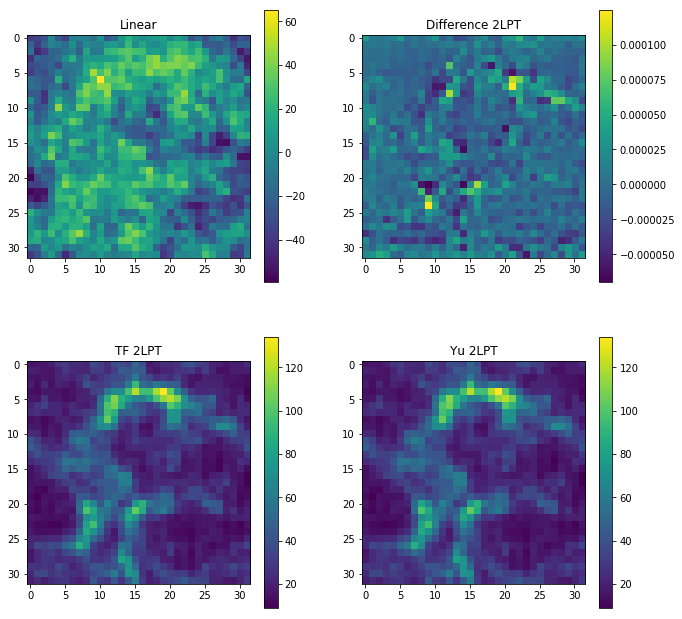

In [84]:
fig, axar = plt.subplots(2, 2, figsize = (11, 11))
ax = axar[0]
im = ax[0].imshow(linear[...].sum(axis=0))
plt.colorbar(im, ax=ax[0])
ax[0].set_title('Linear')
im = ax[1].imshow((lptmesh-tflptmesh)[...].sum(axis=0))
plt.colorbar(im, ax=ax[1])
ax[1].set_title('Difference 2LPT')
ax = axar[1]
im = ax[0].imshow(tflptmesh[...].sum(axis=0))
plt.colorbar(im, ax=ax[0])
ax[0].set_title('TF 2LPT')
im = ax[1].imshow(lptmesh[...].sum(axis=0))
plt.colorbar(im, ax=ax[1])
ax[1].set_title('Yu 2LPT')

